# Identify Object Positions in Images - YOLO vs VLM 

---

Consider the image: `/images/table_scene.jpeg`.

### TASK
Detect the cup on the table and identify it visually by **drawing a bounding box around it on the image itself**.  
You can do this using the provided `utils` functions, or by writing your own.

### Models to Compare
Compare the performance of these three models:

1. **YOLO**
2. **GPT-4.1-mini**
3. **Gemini 2.5-flash**

### Notes
Depending on your prompt choice and the model’s output format, you may need to:

- update the `utils` functions, or  
- adapt your code to make it compatible (e.g., **parsing outputs** that come back as text vs JSON).

---


### Utils 
Some of the utils are taken and modified for the purpose of the exercise from 
https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing#scrollTo=wizbxA1lm-Tj
https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb#scrollTo=245bc92a470f


# YOLO Image Detection

In [1]:
import json
import re
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

#this function is needed to plot bounding boxes on images 
def plot_bounding_boxes(im, positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, ((y1, x1, y2, x2)) in enumerate(positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        #draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# if the boxes coordinates are output not as json but as text, should be parsed first
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result



Detected a mug with confidence 0.118 at location [612.34, 339.0, 724.2, 521.38]
Detected a mug with confidence 0.182 at location [615.11, 545.13, 849.1, 780.34]
Detected a mug with confidence 0.598 at location [613.26, 550.7, 857.34, 784.31]
[612.34, 339.0, 724.2, 521.38]
[615.11, 545.13, 849.1, 780.34]
[613.26, 550.7, 857.34, 784.31]


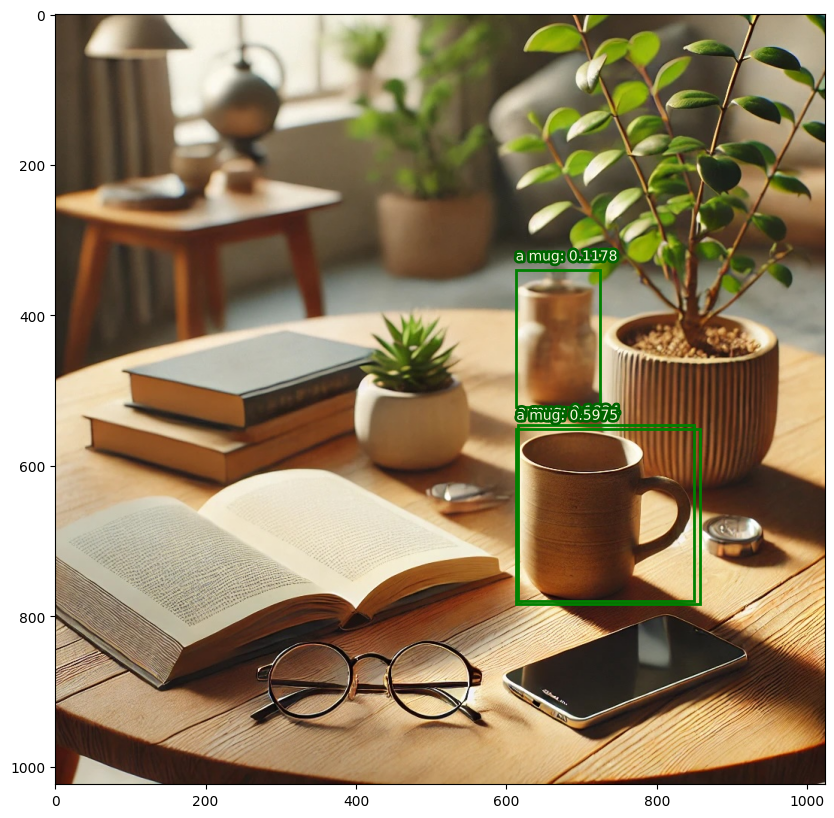

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

image = Image.open("/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg")

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")


text_labels = [["a cup","a mug"]]

inputs = processor(text=text_labels, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.tensor([(image.height, image.width)])

# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.1, text_labels=text_labels
)
# Retrieve predictions for the first image for the corresponding text queries
result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]

for box, score, text_label in zip(boxes, scores, text_labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text_label} with confidence {round(score.item(), 3)} at location {box}")


def show_box(box, ax):
    print(box)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_boxes_and_labels_on_image(raw_image, boxes, labels, scores):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for i, box in enumerate(boxes):
        box = [round(i, 2) for i in box.tolist()]
        show_box(box, plt.gca())
        plt.text(
            x=box[0],
            y=box[1] - 12,
            s=f"{labels[i]}: {scores[i]:,.4f}",
            c="beige",
            path_effects=[pe.withStroke(linewidth=4, foreground="darkgreen")],
        )
    plt.axis("on")
    plt.show()
    #lt.savefig("streetscene_with_detections.jpg")



# Show the image with the bounding boxes
show_boxes_and_labels_on_image(
    image,
    boxes,
    text_labels,
    scores
)


# mit Koordinaten auf dem Bild


DETECTION RESULTS WITH COORDINATES:

{'label': 'a cup', 'confidence': 0.11, 'xmin': 615.11, 'ymin': 545.13, 'xmax': 849.1, 'ymax': 780.34, 'width': 233.99, 'height': 235.21, 'center_x': 732.11, 'center_y': 662.74}

{'label': 'a cup', 'confidence': 0.25, 'xmin': 613.26, 'ymin': 550.7, 'xmax': 857.34, 'ymax': 784.31, 'width': 244.08, 'height': 233.61, 'center_x': 735.3, 'center_y': 667.51}



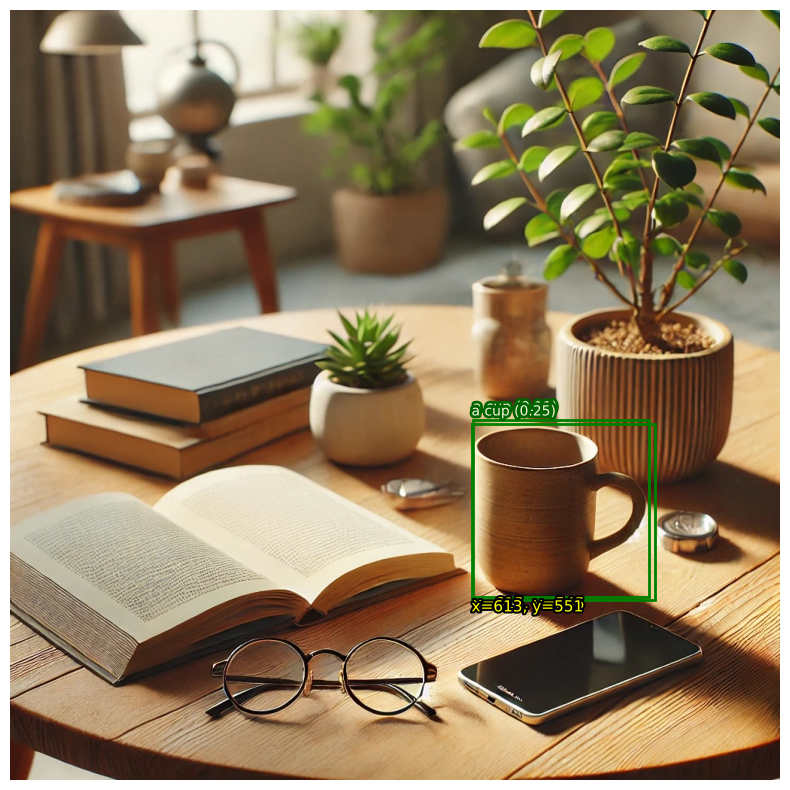

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

image = Image.open("/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg")

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

text_labels = [["a cup"]]

inputs = processor(text=text_labels, images=image, return_tensors="pt")
outputs = model(**inputs)

target_sizes = torch.tensor([(image.height, image.width)])

results = processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.1, text_labels=text_labels
)

result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]

# -------------------------------------------------------
# NEW: Detailed coordinate extraction + printing
# -------------------------------------------------------
detection_list = []

print("\nDETECTION RESULTS WITH COORDINATES:\n")

for box, score, label in zip(boxes, scores, text_labels):
    xmin, ymin, xmax, ymax = [round(x, 2) for x in box.tolist()]
    
    width = round(xmax - xmin, 2)
    height = round(ymax - ymin, 2)
    center_x = round(xmin + width / 2, 2)
    center_y = round(ymin + height / 2, 2)

    det = {
        "label": label,
        "confidence": round(score.item(), 3),
        "xmin": xmin,
        "ymin": ymin,
        "xmax": xmax,
        "ymax": ymax,
        "width": width,
        "height": height,
        "center_x": center_x,
        "center_y": center_y
    }

    detection_list.append(det)
    print(det)
    print()

# -------------------------------------------------------
# Visualization utilities – now with coordinate overlay
# -------------------------------------------------------
def show_box(box, ax):
    x0, y0, x1, y1 = box
    w, h = x1 - x0, y1 - y0
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

def show_boxes_and_labels_on_image(raw_image, boxes, labels, scores):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    ax = plt.gca()

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = [round(v, 2) for v in box.tolist()]
        show_box([xmin, ymin, xmax, ymax], ax)

        # --- LABEL ---
        plt.text(
            x=xmin,
            y=ymin - 12,
            s=f"{labels[i]} ({scores[i]:.2f})",
            c="beige",
            path_effects=[pe.withStroke(linewidth=4, foreground="darkgreen")],
        )

        # --- NEW: COORDINATES UNDER THE BOX ---
        coord_text = f"x={xmin:.0f}, y={ymin:.0f}"
        plt.text(
            x=xmin,
            y=ymax + 15,
            s=coord_text,
            c="yellow",
            fontsize=11,
            path_effects=[pe.withStroke(linewidth=3, foreground="black")],
        )

    plt.axis("off")
    plt.show()

# -------------------------------------------------------
# Show final output
# -------------------------------------------------------
show_boxes_and_labels_on_image(
    image,
    boxes,
    text_labels,
    scores
)


# OpenAI Image Detection

RAW OUTPUT:
 {
  "detections": [
    {
      "label": "cup or mug",
      "confidence": 0.95,
      "box": [580, 410, 660, 520]
    },
    {
      "label": "cup or mug",
      "confidence": 0.85,
      "box": [520, 240, 580, 320]
    }
  ]
}


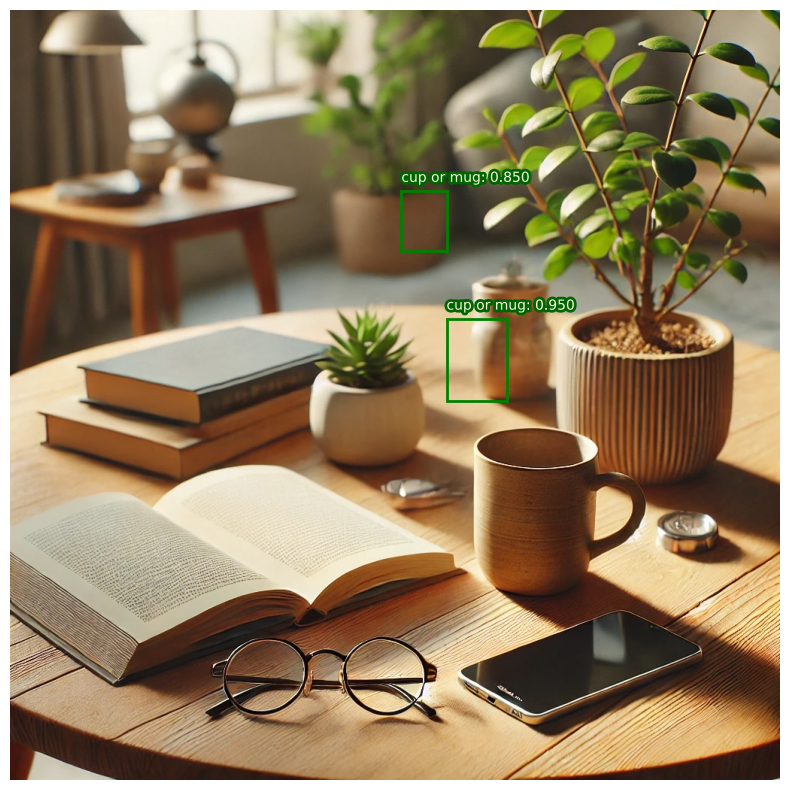

In [4]:
import base64
import re
import json
from openai import OpenAI
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

client = OpenAI()

# -------------------------------------------------------
# Load image
# -------------------------------------------------------
image_path = "/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg"
image = Image.open(image_path)

# Convert image → base64 for API
with open(image_path, "rb") as f:
    image_bytes = f.read()
image_b64 = base64.b64encode(image_bytes).decode("utf-8")

# -------------------------------------------------------
# Prompt enforcing JSON
# -------------------------------------------------------
prompt = """
Extract objects "cup" and "mug" from the image.

Return ONLY valid JSON.
No natural language. No formatting. No markdown.

Schema:
{
  "detections": [
    {
      "label": "cup or mug",
      "confidence": number 0–1,
      "box": [xmin, ymin, xmax, ymax]
    }
  ]
}
"""


response = client.responses.create(
    model="gpt-4.1-mini",
    input=[
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": prompt},
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{image_b64}"
                }
            ]
        }
    ]
)

raw = response.output_text
print("RAW OUTPUT:\n", raw)

# -------------------------------------------------------
# JSON Extraction Helper
# -------------------------------------------------------
def extract_json(text):
    # match the largest {...} block
    matches = re.findall(r'\{[\s\S]*\}', text)
    if not matches:
        raise ValueError("No JSON object found in model output.")
    return matches[0]


try:
    json_text = extract_json(raw)
    data = json.loads(json_text)
except Exception as e:
    print("JSON parsing failed:", e)
    print("RAW text was:", raw)
    raise

detections = data["detections"]

# -------------------------------------------------------
# Plotting helper
# -------------------------------------------------------
def show_box(box, ax):
    x0, y0, x1, y1 = box
    w, h = x1 - x0, y1 - y0
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

def show_boxes_and_labels_on_image(img, detections):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    for det in detections:
        box = det["box"]
        label = det["label"]
        score = det["confidence"]

        show_box(box, ax)
        plt.text(
            x=box[0],
            y=box[1] - 12,
            s=f"{label}: {score:.3f}",
            c="beige",
            path_effects=[pe.withStroke(linewidth=4, foreground="darkgreen")],
        )

    plt.axis("off")
    plt.show()

# -------------------------------------------------------
# Visualize
# -------------------------------------------------------
show_boxes_and_labels_on_image(image, detections)


# mit Koordinaten auf dem Bild

RAW MODEL OUTPUT:
 {
  "detections": [
    {
      "label": "cup",
      "confidence": 0.95,
      "box": [630, 410, 700, 480]
    }
  ]
}

DETECTIONS WITH COORDINATES:

{'label': 'cup', 'confidence': 0.95, 'xmin': 630, 'ymin': 410, 'xmax': 700, 'ymax': 480, 'width': 70, 'height': 70, 'center_x': 665.0, 'center_y': 445.0}



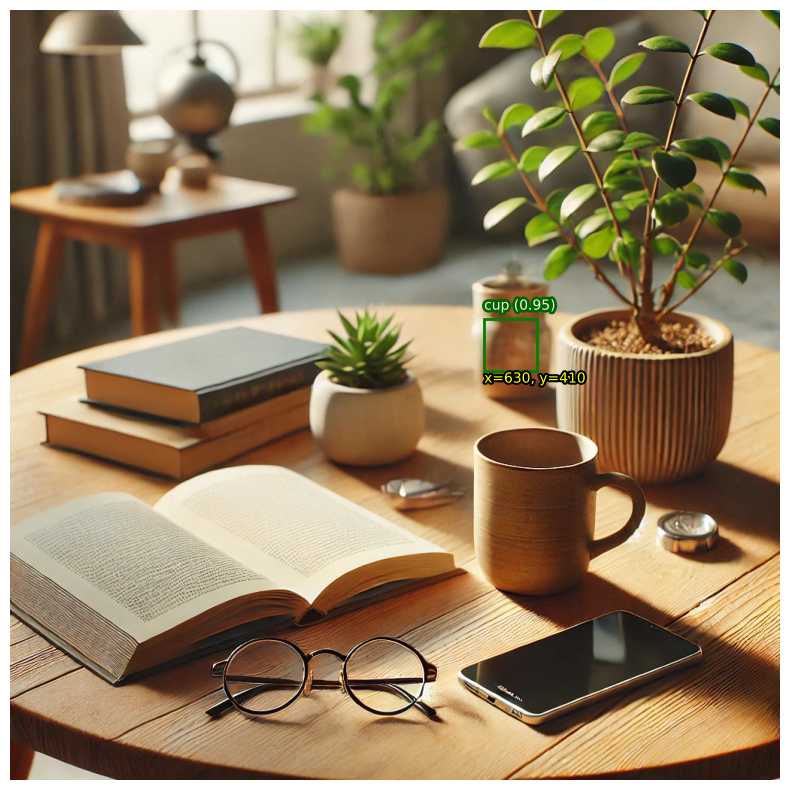

In [8]:
import base64
import re
import json
from openai import OpenAI
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

client = OpenAI()

# -------------------------------------------------------
# Load image
# -------------------------------------------------------
image_path = "/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg"
image = Image.open(image_path)

with open(image_path, "rb") as f:
    image_bytes = f.read()

image_b64 = base64.b64encode(image_bytes).decode("utf-8")

# -------------------------------------------------------
# Force structured JSON output
# -------------------------------------------------------
prompt = """
You are an object detection model.

Detect all "cups" in the image.

Return ONLY valid JSON in this schema:

{
  "detections": [
    {
      "label": "cup",
      "confidence": number,
      "box": [xmin, ymin, xmax, ymax]
    }
  ]
}

Pixel coordinates only.
No descriptions. No markdown. JSON only.
"""

response = client.responses.create(
    model="gpt-4.1-mini",
    input=[
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": prompt},
                {"type": "input_image", "image_url": f"data:image/jpeg;base64,{image_b64}"}
            ]
        }
    ]
)

raw = response.output_text
print("RAW MODEL OUTPUT:\n", raw)

# -------------------------------------------------------
# JSON extraction helper
# -------------------------------------------------------
def extract_json(text):
    match = re.search(r"\{[\s\S]*\}", text)
    if match:
        return match.group(0)
    raise ValueError("No JSON object found.")

json_text = extract_json(raw)
data = json.loads(json_text)

detections = data["detections"]

# -------------------------------------------------------
# Print coordinates in console
# -------------------------------------------------------
print("\nDETECTIONS WITH COORDINATES:\n")
for det in detections:
    xmin, ymin, xmax, ymax = det["box"]
    label = det["label"]
    conf = det["confidence"]

    width = xmax - xmin
    height = ymax - ymin

    print({
        "label": label,
        "confidence": round(conf, 3),
        "xmin": round(xmin, 2),
        "ymin": round(ymin, 2),
        "xmax": round(xmax, 2),
        "ymax": round(ymax, 2),
        "width": round(width, 2),
        "height": round(height, 2),
        "center_x": round(xmin + width/2, 2),
        "center_y": round(ymin + height/2, 2),
    })
    print()

# -------------------------------------------------------
# Draw boxes + coordinates on image
# -------------------------------------------------------
def show_box(box, ax):
    xmin, ymin, xmax, ymax = box
    w, h = xmax - xmin, ymax - ymin
    ax.add_patch(
        plt.Rectangle((xmin, ymin), w, h, edgecolor="green", facecolor=(0,0,0,0), lw=2)
    )

def visualize_detections(img, detections):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    for det in detections:
        xmin, ymin, xmax, ymax = det["box"]
        label = det["label"]
        score = det["confidence"]

        # Draw box
        show_box(det["box"], ax)

        # Draw label
        plt.text(
            x=xmin,
            y=ymin - 12,
            s=f"{label} ({score:.2f})",
            c="beige",
            path_effects=[pe.withStroke(linewidth=4, foreground="darkgreen")]
        )

        # Draw coordinates under the box
        coord_text = f"x={xmin:.0f}, y={ymin:.0f}"
        plt.text(
            x=xmin,
            y=ymax + 15,
            s=coord_text,
            c="yellow",
            fontsize=10,
            path_effects=[pe.withStroke(linewidth=3, foreground="black")]
        )

    plt.axis("off")
    plt.show()

# -------------------------------------------------------
# Show final annotated image
# -------------------------------------------------------
visualize_detections(image, detections)


# Gemini Image Detection

RAW MODEL OUTPUT:
 {
  "detections": [
    {
      "label": "cup or mug",
      "confidence": 0.98,
      "box": [593, 524, 757, 775]
    }
  ]
}

DETECTIONS WITH COORDINATES:

{'label': 'cup or mug', 'confidence': 0.98, 'xmin': 593, 'ymin': 524, 'xmax': 757, 'ymax': 775, 'width': 164, 'height': 251, 'center_x': 675.0, 'center_y': 649.5}



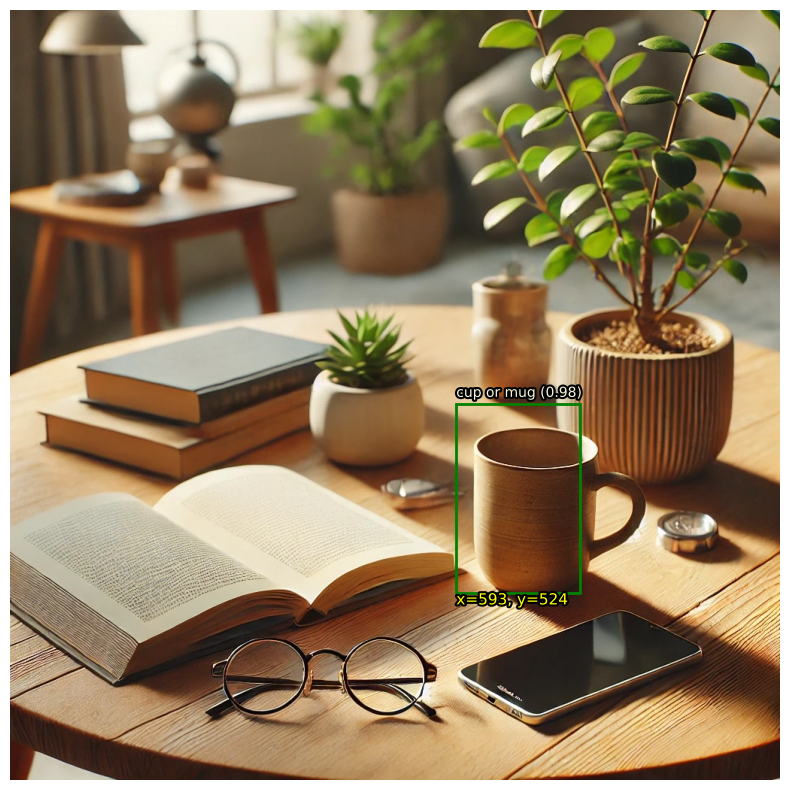

In [2]:
# -------------------------------------------------------
# Imports
# -------------------------------------------------------
import google.generativeai as genai
import base64
import json
import re
import os
from PIL import Image
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# -------------------------------------------------------
# .env laden und API Key setzen
# -------------------------------------------------------
load_dotenv()
API_KEY = os.getenv("GEMINI_API_KEY")

if not API_KEY:
    raise ValueError("GEMINI_API_KEY not found in .env. Please check your configuration.")

genai.configure(api_key=API_KEY)

# Modell definieren
model = genai.GenerativeModel("gemini-2.5-flash")

# -------------------------------------------------------
# Bild laden
# -------------------------------------------------------
image_path = "/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg"
image = Image.open(image_path)

with open(image_path, "rb") as f:
    image_bytes = f.read()

image_b64 = base64.b64encode(image_bytes).decode("utf-8")

# -------------------------------------------------------
# Prompt für strukturierte Detection
# -------------------------------------------------------
prompt = """
You are an object detection model.

Detect all "cups" and "mugs" and return ONLY valid JSON:

{
  "detections": [
    {
      "label": "cup or mug",
      "confidence": number,
      "box": [xmin, ymin, xmax, ymax]
    }
  ]
}

Pixel coordinates only.
No explanation.
No markdown.
Return only JSON.
"""

# -------------------------------------------------------
# Anfrage ans Modell
# -------------------------------------------------------
response = model.generate_content(
    [
        prompt,
        {
            "mime_type": "image/jpeg",
            "data": base64.b64decode(image_b64),
        }
    ]
)

raw = response.text
print("RAW MODEL OUTPUT:\n", raw)

# -------------------------------------------------------
# JSON Extraction Helper
# -------------------------------------------------------
def extract_json(text):
    match = re.search(r"\{[\s\S]*\}", text)
    if match:
        return match.group(0)
    raise ValueError("No JSON inside Gemini output.")

# JSON extrahieren
json_text = extract_json(raw)
data = json.loads(json_text)

detections = data["detections"]

# -------------------------------------------------------
# Print detection coordinates
# -------------------------------------------------------
print("\nDETECTIONS WITH COORDINATES:\n")
for det in detections:
    xmin, ymin, xmax, ymax = det["box"]
    label = det["label"]
    conf = det["confidence"]

    width = xmax - xmin
    height = ymax - ymin
    cx = xmin + width / 2
    cy = ymin + height / 2

    print({
        "label": label,
        "confidence": round(conf, 3),
        "xmin": round(xmin, 2),
        "ymin": round(ymin, 2),
        "xmax": round(xmax, 2),
        "ymax": round(ymax, 2),
        "width": round(width, 2),
        "height": round(height, 2),
        "center_x": round(cx, 2),
        "center_y": round(cy, 2),
    })
    print()

# -------------------------------------------------------
# Visualization utilities
# -------------------------------------------------------
def show_box(box, ax):
    x0, y0, x1, y1 = box
    w, h = x1 - x0, y1 - y0
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

def visualize_detections(img, detections):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    for det in detections:
        xmin, ymin, xmax, ymax = det["box"]
        label = det["label"]
        score = det["confidence"]

        show_box([xmin, ymin, xmax, ymax], ax)

        # Label above box
        plt.text(
            x=xmin,
            y=ymin - 10,
            s=f"{label} ({score:.2f})",
            c="beige",
            path_effects=[pe.withStroke(linewidth=3, foreground="black")]
        )

        # Coordinates below box
        coord_text = f"x={xmin:.0f}, y={ymin:.0f}"
        plt.text(
            x=xmin,
            y=ymax + 15,
            s=coord_text,
            c="yellow",
            fontsize=11,
            path_effects=[pe.withStroke(linewidth=3, foreground="black")]
        )

    plt.axis("off")
    plt.show()

# -------------------------------------------------------
# Bild anzeigen
# -------------------------------------------------------
visualize_detections(image, detections)

